===================================================
## 6. AAE-deriv
#### AAE trained to predict the time deriv $\dot{\alpha}_n = f(\alpha_n)$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

NameError: name 'notebookName' is not defined

In [3]:
notebookName = 'AAE-deriv.ipynb'

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

In [6]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n',value) # MUST RETURN True IF IT CAN!!
print('\n')
print("***Num GPUs Available: ***\n", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***
 True


***Num GPUs Available: ***
 1


## Load data

In [7]:
data_dir = './../data/preprocessed/single_domain/'
pod_coeffs = np.load(data_dir + 'pod_coeffs_1.npy')  
pod_coeffs.shape

(1, 10, 1999)

In [8]:
npod = 5
X_pod = np.transpose(pod_coeffs.reshape(10, 1999)[:npod])
step = 0.25
times = np.arange(0, len(X_pod), step, dtype="float64")

X_pod.shape

(1999, 5)

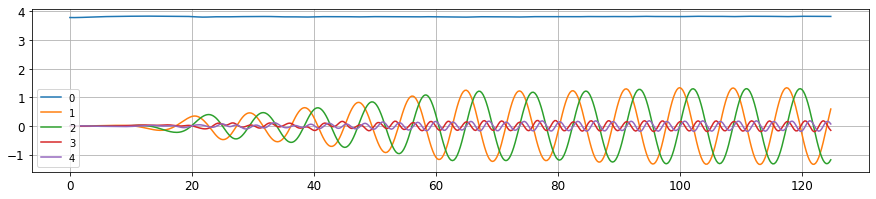

In [9]:
fig, ax = plt.subplots(1,1, figsize=[15,3])
ax.plot(times[0:500], X_pod[0:500]);
ax.grid()
ax.legend(range(5),loc='lower left')

## Prepare data

In [10]:
def calculate_deriv(X_train, step=step):
    """
    Calculate the 1st order time derivative by (a_n+1 - a_n)/step.
    """
    X_deriv = [[] for i in range(len(X_train)-1)]
    for i in range(len(X_deriv)):
        for j in range(5):
            X_deriv[i].append((X_train[i+1, j] - X_train[i, j]) / step)
    return np.array(X_deriv)

In [11]:
X_deriv_1 = calculate_deriv(X_pod, step=step)
X_deriv_2 = calculate_deriv(X_deriv_1, step=step)
X_deriv_3 = calculate_deriv(X_deriv_2, step=step)

#a0, (a1-a0)/t, ((a2-a1)-(a1-a0))/t^2, ...
X_train = np.concatenate((X_pod[:-3], X_deriv_1[:-2], X_deriv_2[:-1], 
                          X_deriv_3), axis=1)
X_train.shape

(1996, 20)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
np.allclose(X_train, scaler.inverse_transform(X_train_scaled))

True

In [13]:
nderiv = 3
x_train = X_train_scaled[:, :nderiv*npod]
y_train = X_train_scaled[:, -npod:]
print(x_train.shape, y_train.shape)

(1996, 15) (1996, 5)


## Train the AAE

In [14]:
import wandb

# Initialize a new run and set hyperparameters
#wandb.login(key='356a5933239117f23bf9483081f3ca58e5efbe8b')  #Use this key to log in
wandb.init(project='tsp-ai', group='aae', entity='tinayzh')
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# config is a variable that holds and saves hyper parameters and inputs
config = wandb.config  # Initialize config

config.datagroup = 'new' #'new_submean'
config.npod = npod
config.ndomain = 1
config.nderiv_order = nderiv
#config.ntimes = ntimes # Consecutive times for the GAN
#config.ntime_step = level_step # step between time levels

#config.seed = 42  # random seed(default:42)
config.batch_size = 16  # input batch size for training (default:64)
config.latent_space = 100

config.architechture = 'AAE_deriv_sigmoid'
config.dropout = 0
config.activate = 'sigmoid'
config.optimizer = 'Nadam'
config.lr = 1e-4  # learning rate(default:0.01)

config.epochs = 200  # number of epochs to train(default:10)
#config.no_cuda = False  # disables CUDA training
config.log_interval = 10  # how many batches to wait before logging training status

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tinayzh (use `wandb login --relogin` to force relogin)


In [15]:
batch_size = config.batch_size
latent_space = config.latent_space
dropout = config.dropout
activate = config.activate
lr = config.lr
epochs = config.epochs

In [16]:
import sys
sys.path.append("..")

# Built package imports
from PredAAE.models import Predictive_adversarial
from PredAAE.architectures.cae.D2 import *
from PredAAE.architectures.svdae import *
from PredAAE.architectures.discriminators import *

In [17]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005, beta_1=0.98, beta_2=0.99999)

encoder, decoder = build_deriv_encoder_decoder(npod, latent_space, initializer, 
                                                  dropout=dropout, reg=0, final_act=activate, info=False)
discriminator = build_custom_discriminator(latent_space, initializer, info=False)

In [18]:
pred_aae = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_aae.compile(npod)

In [19]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              122880    
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         147456    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         5

In [20]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               25600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36864     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 64)         

In [21]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 61,101
Trainable params: 0
Non-trainable params: 61,101
_________________________________________________________________


In [22]:
with tf.device("/gpu:0"):
    hist = pred_aae.train_preprocessed(x_train, y_train, epochs=epochs, val_size=0.1, 
                                       batch_size=batch_size, wandb_log=True, n_discriminator=1)

Epoch 1/200
discriminator train_loss: 0.319865 - generator train_loss: 0.080539 - discriminator val_loss: 0.069039 - generator val_loss: 0.098785 - 19s
Epoch 2/200
discriminator train_loss: 0.054489 - generator train_loss: 0.046414 - discriminator val_loss: 0.017950 - generator val_loss: 0.086031 - 10s
Epoch 3/200
discriminator train_loss: 0.038222 - generator train_loss: 0.029948 - discriminator val_loss: 0.010495 - generator val_loss: 0.073022 - 10s
Epoch 4/200
discriminator train_loss: 0.036892 - generator train_loss: 0.022510 - discriminator val_loss: 0.009315 - generator val_loss: 0.030011 - 10s
Epoch 5/200
discriminator train_loss: 0.035913 - generator train_loss: 0.015442 - discriminator val_loss: 0.009777 - generator val_loss: 0.014612 - 10s
Epoch 6/200
discriminator train_loss: 0.035789 - generator train_loss: 0.012734 - discriminator val_loss: 0.008822 - generator val_loss: 0.011482 - 10s
Epoch 7/200
discriminator train_loss: 0.035523 - generator train_loss: 0.013420 - discri

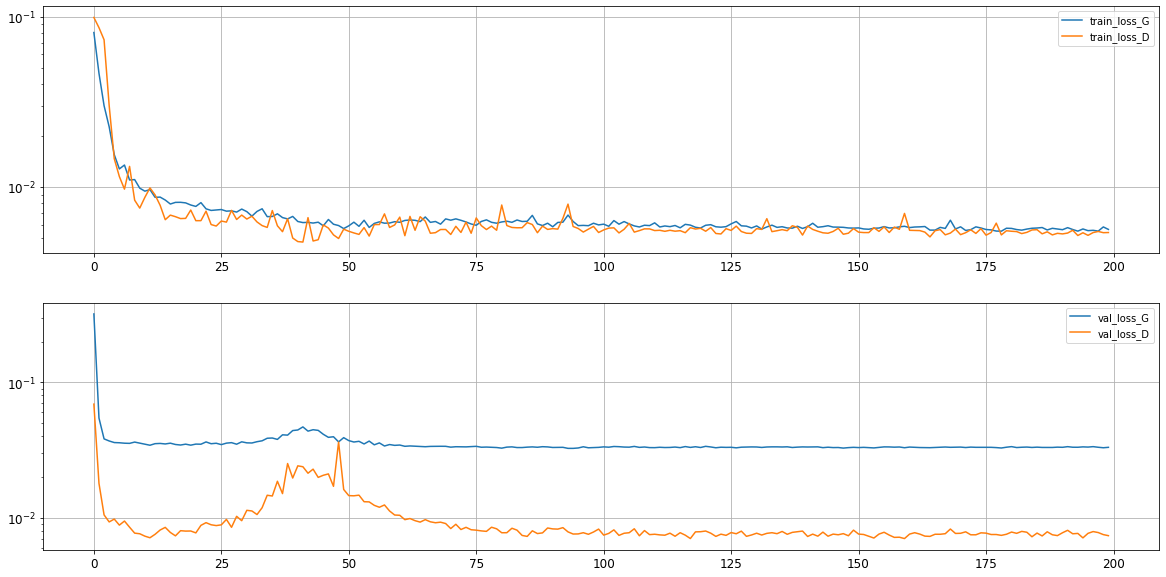

In [23]:
fig, ax = plt.subplots(2, 1, figsize=[20,10])
ax[0].plot(hist[:, 0])
ax[0].plot(hist[:, 2])
ax[0].legend(['train_loss_G', 'train_loss_D'])
ax[0].set_yscale('log')
ax[0].grid()

ax[1].plot(hist[:, 1])
ax[1].plot(hist[:, 3])
ax[1].legend(['val_loss_G', 'val_loss_D'])
ax[1].set_yscale('log')
ax[1].grid()

In [24]:
import joblib
joblib.dump(scaler, "models/scaler-deriv_arch_sigm.pkl")
#encoder.save("models/encoder-deriv-3.h5")
#decoder.save("models/decoder-deriv-3.h5")
#discriminator.save("models/discriminator-deriv-3.h5")
pred_aae.save(dirname="models/deriv_arch_sigm")

INFO:tensorflow:Assets written to: models/deriv_arch_sigm/encoder/assets
INFO:tensorflow:Assets written to: models/deriv_arch_sigm/decoder/assets
INFO:tensorflow:Assets written to: models/deriv_arch_sigm/discriminator/assets


## Predict one next time level

In [25]:
result = pred_aae.adversarial_autoencoder.predict(x_train)
result[0].shape
#result_new = result[0]

(1996, 5)

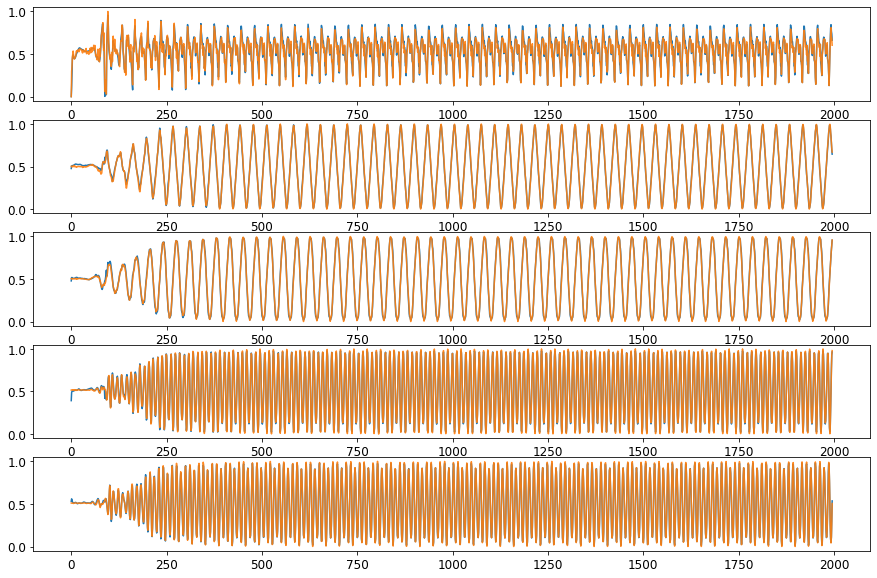

In [26]:
fig, ax = plt.subplots(5,1, figsize=[15,10])
for i in range(5):
    ax.flatten()[i].plot(result[0][:,i])
    ax.flatten()[i].plot(y_train[:,i], alpha=0.9)

In [27]:
X_true = y_train
X_pred = result[0]

In [28]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0232


### Calculate next time level

In [29]:
X_generated = np.concatenate((x_train, X_pred), axis=1)
X_generated.shape

(1996, 20)

In [30]:
X_generated = scaler.inverse_transform(X_generated)

In [31]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

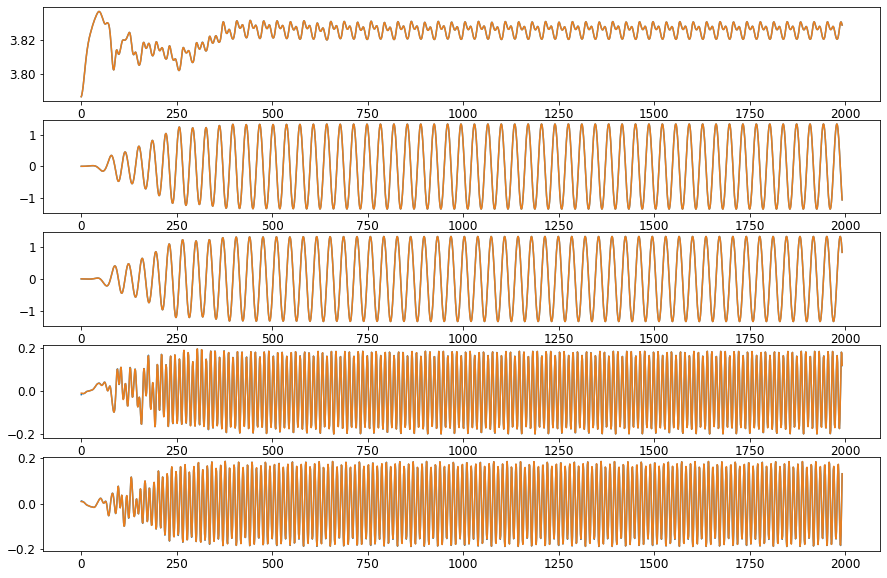

In [32]:
fig, ax = plt.subplots(5,1, figsize=[15,10])
for i in range(5):
    ax.flatten()[i].plot(X_3[:-3,i])
    ax.flatten()[i].plot(X_0[3:,i], alpha=0.9)

In [33]:
X_true = X_0[3:]
X_pred = X_3[:-3]

In [34]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0007


## Predict multiple points
In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction.

In [35]:
def predict_next_time_level(x_test, nstep, npredict):
    y_predall = []
    for i in range(npredict):
        yhat = pred_aae.adversarial_autoencoder.predict(x_test)
        yhat_inv = np.concatenate((x_test, yhat[0]), axis=1)
        yhat_inv = scaler.inverse_transform(yhat_inv)
        y0 = yhat_inv[:, :5]
        y1 = step * yhat_inv[:, 5:10] + y0
        y2 = step**2 * yhat_inv[:, 10:15] + 2*y1 - y0
        y3 = step**3 * yhat_inv[:, 15:20] + 3*y2 - 3*y1 + y0
        y_predall.append(y3[-3])

        dy1 = calculate_deriv(y3[-3:], step=step)
        dy2 = calculate_deriv(dy1, step=step)
        dy3 = yhat_inv[-1, 15:20]    #here dy3 is at the last time level, only use to fit transform
        y_next = np.concatenate(([y3[-3]], [dy1[0]], dy2, [dy3]), axis=1)
        y_next = scaler.transform(y_next)
        y_next = y_next[:, :15]
        x_test = np.concatenate((x_test, [y_next[-1]]), axis=0)[-nstep:,:]
        
    return np.array(y_predall)

### Start point = time step 100

In [137]:
n = 100
nstep_init = 19
npred = 100    # term = 35
time_level_pred = predict_next_time_level(x_train[n:nstep_init+n], nstep_init, npred)
times_pred = np.arange(0, (len(X_pod)+npred)*step, step, dtype="float64")
x_pred = np.concatenate((X_train[n:n+nstep_init, :5], time_level_pred), axis=0)

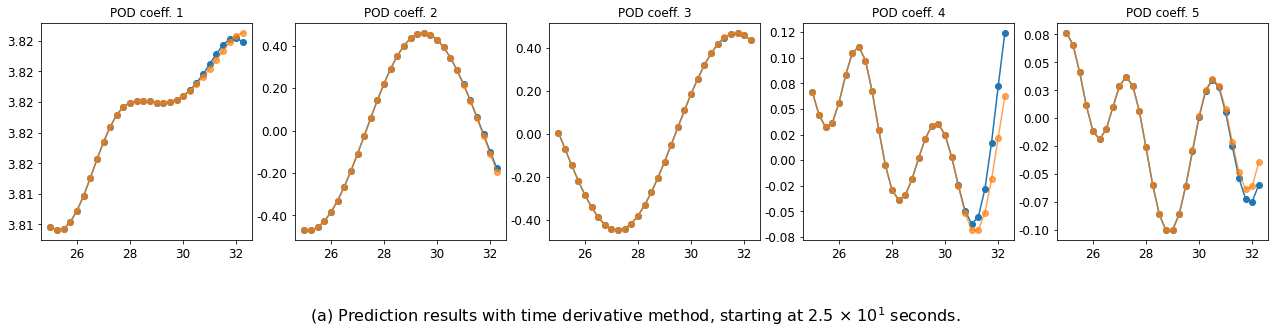

In [131]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times_pred[n:n+30], x_pred[:30,i],'-o')
    ax.flatten()[i].plot(times[n:n+30], X_train[n:n+30, i], '-o', alpha=0.7)
my_suptitle = plt.suptitle("(a) Prediction results with time derivative method, starting at 2.5 × $10^1$ seconds.", y=-0.1, fontsize=16)
plt.savefig('images/AAE_deriv_100.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

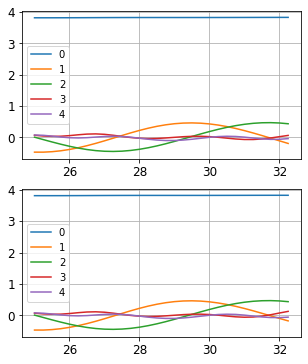

In [55]:
fig, ax = plt.subplots(2,1, figsize=[5,6])
ax[0].plot(times[n:n+30], X_pod[n:n+30]);
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times_pred[n:n+30], x_pred[:30]);
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [139]:
out_dir = './../data/outputs/'
pod_coeffs_gen = np.transpose(x_pred)
np.savetxt(out_dir+'aae_deriv_100.csv', pod_coeffs_gen , delimiter=',')

# generate reconstructed pod coeffs
pod_basis = np.load(data_dir+'pod_basis_1.npy')
reconstructed = np.reshape((pod_basis[:,:5] @ pod_coeffs_gen), [1, 2, 221, 42, -1])

np.save(out_dir+'aae_deriv_100.npy', reconstructed)

Calculate error and relative error

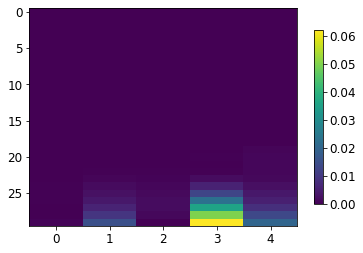

In [57]:
X_true = X_pod[n:n+30]
X_pred = x_pred[:30]
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

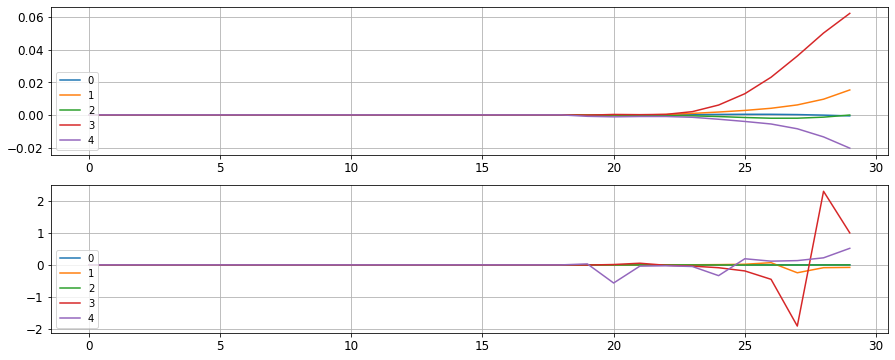

In [58]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [59]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0080


### Start point = time step 1000

In [132]:
n = 1000
nstep_init = 19
npred = 100    # term = 35
time_level_pred = predict_next_time_level(x_train[n:nstep_init+n], nstep_init, npred)
times_pred = np.arange(0, (len(X_pod)+npred)*step, step, dtype="float64")
x_pred = np.concatenate((X_train[n:n+nstep_init, :5], time_level_pred), axis=0)

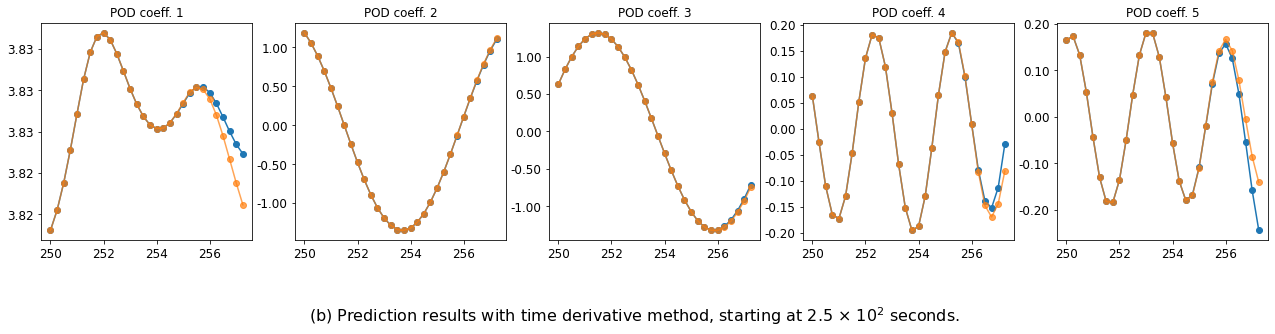

In [133]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times_pred[n:n+30], x_pred[:30,i],'-o')
    ax.flatten()[i].plot(times[n:n+30], X_train[n:n+30, i], '-o', alpha=0.7)
my_suptitle = plt.suptitle("(b) Prediction results with time derivative method, starting at 2.5 × $10^2$ seconds.", y=-0.1, fontsize=16)
plt.savefig('images/AAE_deriv_1000.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


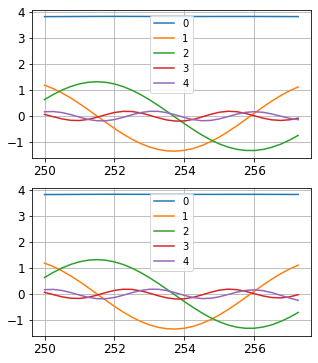

In [109]:
fig, ax = plt.subplots(2,1, figsize=[5,6])
ax[0].plot(times[n:n+30], X_pod[n:n+30]);
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times_pred[n:n+30], x_pred[:30]);
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [135]:
out_dir = './../data/outputs/'
pod_coeffs_gen = np.transpose(x_pred)
np.savetxt(out_dir+'aae_deriv_1000.csv', pod_coeffs_gen , delimiter=',')

# generate reconstructed pod coeffs
pod_basis = np.load(data_dir+'pod_basis_1.npy')
reconstructed = np.reshape((pod_basis[:,:5] @ pod_coeffs_gen), [1, 2, 221, 42, -1])

np.save(out_dir+'aae_deriv_1000.npy', reconstructed)

Calculate error and relative error

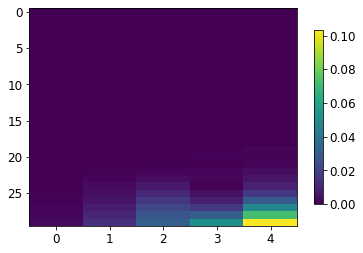

In [111]:
X_true = X_pod[n:n+30]
X_pred = x_pred[:30]
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

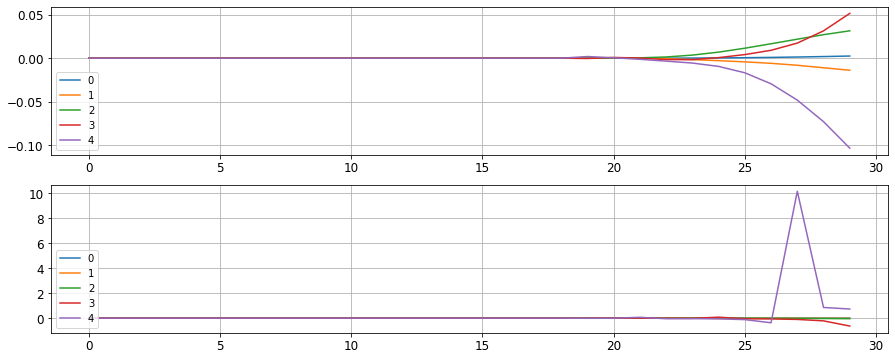

In [112]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [113]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0133
